In [2]:
import math
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import grblogtools as glt
import sys
unit_name = "Quận 7"
# Redirect terminal output to a log file
log_filename = f'results_unit_{unit_name}.log'
sys.stdout = open(log_filename, 'w')


# Close the log file
sys.stdout.close()

# Reset stdout
sys.stdout = sys.__stdout__

# Parse the log file using grblogtools
results = glt.parse(log_filename)
summary = results.summary

# Print the summary
print(summary)

In [2]:
python -m pip install grblogtools

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2633518692.py, line 1)

In [4]:
# Step 1: Load Constraint data and other required data upfront
Constraint_df = pd.read_csv('CONSTRAINT.csv')  # Columns: ['Unit', 'Budget', 'Demand', 'Slot', 'POI_df', 'MIPGap']
People_df = pd.read_csv('PEOPLE.csv')  # Static People data assumed as it doesn't vary per Unit
# Ensure numeric fields are correctly formatted
Constraint_df[['Budget', 'Demand', 'Slot', 'MIPGap']] = Constraint_df[['Budget', 'Demand', 'Slot', 'MIPGap']].apply(pd.to_numeric, errors='coerce')
People_df['Cars'] = pd.to_numeric(People_df['Cars'], errors='coerce')
# Earth's radius in kilometers for the Haversine formula
R = 6371.0

# Define the Haversine function to calculate the distance between POIs and People nodes
def haversine(lat1, lon1, lat2, lon2):
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    return 2 * R * math.asin(math.sqrt(a))

print(Constraint_df)
print(People_df)

                Unit        Budget  Demand  Slot    POI_df    MIPGap
0             Quận 7   74631999960   35878   717   POI.csv  0.000001
1             Quận 6   48398951959   23267   465  POI4.csv  0.000050
2             Quận 8   88000298558   42304   845  POI4.csv  0.000050
3            Quận 10   48659637097   23392   467  POI4.csv  0.000001
4         TP Thủ Đức  242442773522  116549  2329   POI.csv  0.000001
5           Quận một   29555022128   14208   284   POI.csv  0.000100
6             Quận 3   39449867397   18965   379   POI.csv  0.000001
7             Quận 5   32963407782   15846   317   POI.csv  0.000001
8            Quận 11   43489036486   20906   418   POI.csv  0.000010
9            Quận 12  128507826484   61777  1234  POI4.csv  0.000001
10       Quận Gò Vấp  140268290434   67431  1347  POI4.csv  0.000001
11     Quận Tân Bình   98387295818   47297   945   POI.csv  0.000050
12      Quận Tân Phú  100574730093   48349   966   POI.csv  0.000010
13   Quận Bình Thạnh  103437707732

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2555171
Academic license 2555171 - for non-commercial use only - registered to vu___@naist.ac.jp
Processing unit: Quận 7 with Budget: 74631999960, Demand: 35878, Slot: 717
Discarded solution information
Set parameter MIPGap to value 1e-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F82)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2555171 - for non-commercial use only - registered to vu___@naist.ac.jp
Optimize a model with 111 rows, 1620 columns and 4320 nonzeros
Model fingerprint: 0xe891f86d
Model has 10800 quadratic objective terms
Model has 1080 general constraints
Variable types: 0 continuous, 1620 integer (540 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [7e+05, 4e+06]
  Bounds range     [1e+00, 6e+00]
  RHS range        [6

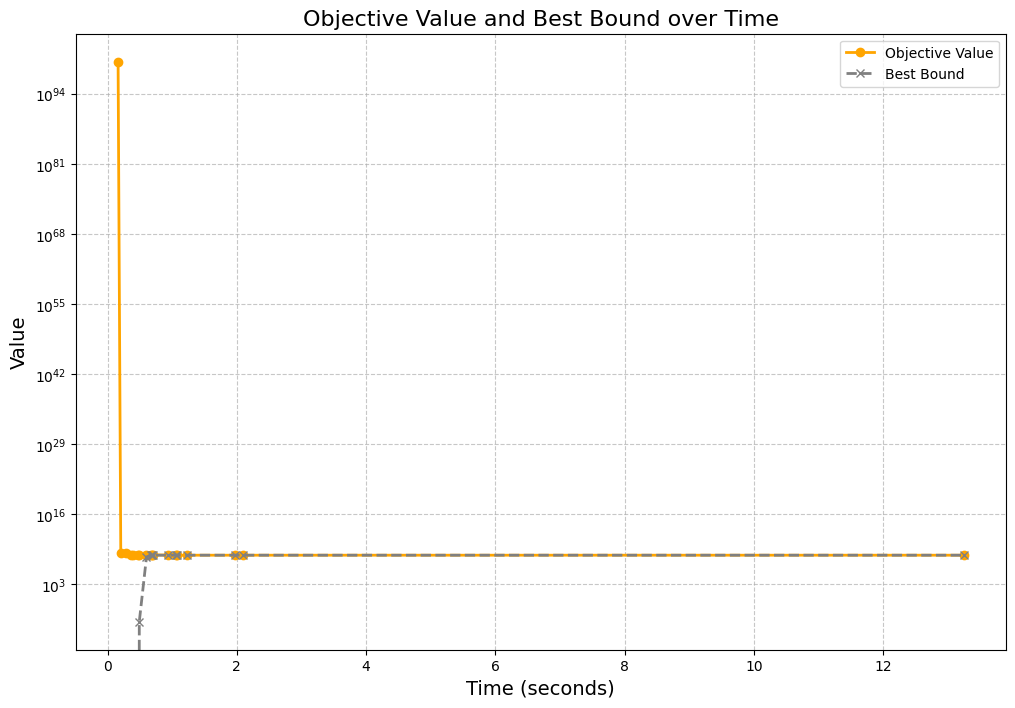

The plot has been saved as 'optimization_plot.png'.


In [5]:
# Initialize Gurobi environment once
with gp.Env(params=options) as env:
    # Initialize the model outside the loop
    model = gp.Model(env=env)

    # Prepare to collect all results in memory
    all_results = []
    all_callback_data = []

# Iterate over each Unit in Constraint_df to run the optimization process
    # Extract dynamic values from the current row
    unit_name = "Quận 7"
    POI_filename = 'POI.csv'  # File name for the POI CSV as defined in the row
    mip_gap = 0.00001      # MIPGap value as defined in the row

    # Load the respective POI data dynamically and filter data for the current unit
    POI_df = pd.read_csv(POI_filename)
    POI_df['Land_Cost'] = pd.to_numeric(POI_df['Land_Cost'], errors='coerce')
    POI_group = POI_df[POI_df['Unit'] == unit_name]
    People_group = People_df[People_df['Unit'] == unit_name]

    # Extract the budget, demand, and slot constraints for the current unit
    Budget = 74631999960
    Demand = 35878
    Slot = 717

    print(f"Processing unit: {unit_name} with Budget: {Budget}, Demand: {Demand}, Slot: {Slot}")

    # Reset the model for new data
    model.reset()  
    model.setParam('MIPGap', mip_gap)

    # Create decision variables for each POI-People pair
    x2 = model.addMVar((len(People_group), len(POI_group)), vtype=GRB.INTEGER, lb=0, ub=6, name="x2")
    x3 = model.addMVar((len(People_group), len(POI_group)), vtype=GRB.INTEGER, lb=0, ub=6, name="x3")
    b = model.addMVar((len(People_group), len(POI_group)), vtype=GRB.BINARY, name="b")

    # Define the objective function to minimize total cost
    total_cost = gp.QuadExpr()
    for i in range(len(POI_group)):
        land_cost = POI_group.iloc[i]['Land_Cost'] / 14_600 * (x2.sum(axis=0)[i] + x3.sum(axis=0)[i]) * b.sum(axis=0)[i]
        fixed_cost = 362_359 * x2.sum(axis=0)[i] * b.sum(axis=0)[i] + 1_751_600 * x3.sum(axis=0)[i] * b.sum(axis=0)[i]
        transportation_cost = gp.QuadExpr()
        for j in range(len(People_group)):
            dist = haversine(POI_group.iloc[i]['Lat1'], POI_group.iloc[i]['Lon1'], People_group.iloc[j]['Lat2'], People_group.iloc[j]['Lon2'])
            transportation_cost += (4_871 * x2[j, i] + 26_571 * x3[j, i]) * dist * b[j, i]

        total_cost += land_cost + fixed_cost + transportation_cost

    # Set the objective function to minimize the total cost
    model.setObjective(total_cost, GRB.MINIMIZE)

    # Add constraints
    model.addConstr((21_349 * x2.sum() + 90_784 * x3.sum()) <= (Budget / 3650), "Total_Charger_Upper_Bound")
    model.addConstr((224.4 * 0.2 * x2.sum() + 1_224 * 0.2 * x3.sum()) >= Demand, "Total_Charger_Lower_Bound")
    model.addConstr((x2.sum() + x3.sum()) <= Slot, "Total_Charger_Slot_Bound")
    for i in range(len(POI_group)):
        for j in range(len(People_group)):
            model.addConstr((b[j, i] == 0) >> (x2[j, i] + x3[j, i] == 0), "if else constraint_1")
            model.addConstr((b[j, i] == 1) >> (x2[j, i] + x3[j, i] >= 1), "if else constraint_2")
        model.addConstr(x2.sum(axis=0)[i] <= 6)
        model.addConstr(x3.sum(axis=0)[i] <= 6)

    # Define the callback function to collect data during optimization
    def data_cb(model, where):
        if where == gp.GRB.Callback.MIP and len(model._data) < 100:  # Limit data collection frequency
            cur_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
            cur_bd = model.cbGet(gp.GRB.Callback.MIP_OBJBND)
            if model._obj != cur_obj or model._bd != cur_bd:
                model._obj = cur_obj
                model._bd = cur_bd
                model._data.append([time.perf_counter() - model._start, cur_obj, cur_bd])

    # Initialize callback data
    model._obj = None
    model._bd = None
    model._data = []
    model._start = time.perf_counter()

    # Optimize the model with callback
    model.optimize(callback=data_cb)

    # Collect results in memory
    all_results.append({
        'unit': unit_name,
        'x2_values': x2.X,
        'x3_values': x3.X,
        'b_values': b.X,
        'optimal_solution': model.ObjVal
    })
    all_callback_data.extend(model._data)

# Save all results to a single CSV file
with open('all_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for result in all_results:
        writer.writerow([f"Results for unit: {result['unit']}"])
        writer.writerow(['x2 values'])
        writer.writerows(result['x2_values'])
        writer.writerow([])
        writer.writerow(['x3 values'])
        writer.writerows(result['x3_values'])
        writer.writerow([])
        writer.writerow(['b values'])
        writer.writerows(result['b_values'])
        writer.writerow([])
        writer.writerow(['Optimal Solution'])
        writer.writerow([result['optimal_solution']])
        writer.writerow([])

# Save all callback data to a CSV file
callback_data_filename = 'all_callback_data.csv'
with open(callback_data_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Time', 'Objective Value', 'Best Bound'])
    writer.writerows(all_callback_data)

# Plot results
data = pd.read_csv(callback_data_filename)
plt.figure(figsize=(12, 8))
plt.plot(data['Time'], data['Objective Value'], label='Objective Value', color='orange', linewidth=2, marker='o')
plt.plot(data['Time'], data['Best Bound'], label='Best Bound', color='gray', linewidth=2, linestyle='--', marker='x')
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Objective Value and Best Bound over Time', fontsize=16)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig('optimization_plot.png')
plt.show()
print("The plot has been saved as 'optimization_plot.png'.")


In [1]:
import pandas as pd
import folium

# Load the CSV file into a DataFrame
file_path = 'output_visualize/Combined_Output.csv'  # Replace with the actual path to your CSV file
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to check the structure and verify the content
print(data.head())

# Optionally, print the column names to verify them
print(data.columns)

         Unit      Type  Value  Column  Row  x coordinate  y coordinate
0  TP Thủ Đức  x2 value    6.0      84    1     10.745962    106.618166
1  TP Thủ Đức  x3 value    6.0      84    1     10.745962    106.618166
2  TP Thủ Đức  x2 value    6.0     122    1     10.887768    106.723144
3  TP Thủ Đức  x3 value    6.0     122    1     10.887768    106.723144
4  TP Thủ Đức  x3 value    6.0     124    1     10.877259    106.722954
Index(['Unit', 'Type', 'Value', 'Column', 'Row', 'x coordinate',
       'y coordinate'],
      dtype='object')
